
![fgr](https://imgur.com/mcNBeoo.jpeg)

# AI in Finance: Data-Driven Investment Strategies with Python
## Factors Affecting USA National Home Prices

**Sara Kuqja**

**Date: 08/08/2024**




# Introduction
"""
This project aims to analyze the factors affecting USA national home prices using data obtained from  [Kaggle](https://www.kaggle.com/datasets/madhurpant/factors-affecting-usa-national-home-prices/suggestions?status=pending&yourSuggestions=true). The dataset includes various economic indicators that potentially influence home prices, such as GDP, unemployment rate, federal funds rate, and more. The objective is to build a predictive model using Random Forest Classifier to make investment decisions based on the predicted trends in home prices. Additionally, the project involves visualizing relationships between different variables and evaluating the importance of each feature in the predictive model.
"""

# Data Description
"""
The dataset includes the following key indicators:

- Home Price Index (HPI): A measure of the price changes in residential housing.
- GDP: Gross Domestic Product, a measure of the economic performance of the country.
- Population Growth Rate: The rate at which the population of the country is growing.
- Mortgage Rate: The interest rate charged on home mortgages.
- Unemployment Rate: The percentage of the labor force that is unemployed.
- Federal Funds Rate: The interest rate at which depository institutions trade federal funds with each other overnight.
- Consumer Price Index (CPI): A measure that examines the weighted average of prices of a basket of consumer goods and services.
"""

# Main Ideas and Code Explanation

# Data Preparation
"""
The data preparation involves loading the dataset, calculating the growth rate of the Home Price Index, and defining the target variable based on the growth rate and federal funds rate. This target variable categorizes the data into 'Buy', 'Sell', or 'Hold' decisions.
"""


In [65]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

In [67]:

# File paths
file_paths = {
    'ConsumerPriceIndex': '/content/drive/MyDrive/data/Consumer-Price-Index.csv',
    'FedFunds': '/content/drive/MyDrive/data/FedFunds.csv',
    'GDP': '/content/drive/MyDrive/data/GDP.csv',
    'HomeIndex': '/content/drive/MyDrive/data/Home-Price-Index.csv',
    'Mortgage': '/content/drive/MyDrive/data/Mortgage.csv',
    'PopulationGrowth': '/content/drive/MyDrive/data/Population-Growth.csv',
    'Unemployment': '/content/drive/MyDrive/data/Unemployment-Rate.csv'
}

# Load and process the data
dataframes = {}
for key, path in file_paths.items():
    df = pd.read_csv(path)
    df['DATE'] = pd.to_datetime(df['DATE'])
    df.set_index('DATE', inplace=True)
    dataframes[key] = df

# Accessing the DataFrames
ConsumerPriceIndex = dataframes['ConsumerPriceIndex']
Mortgage = dataframes['Mortgage']
Unemployment = dataframes['Unemployment']
FedFunds = dataframes['FedFunds']
GDP = dataframes['GDP']
HomeIndex = dataframes['HomeIndex']
PopulationGrowth = dataframes['PopulationGrowth']

# Display the first few rows of each dataframe to ensure they are loaded correctly
print("Consumer Price Index Data:")
print(ConsumerPriceIndex.head())

print("\nMortgage Data:")
print(Mortgage.head())

print("\nUnemployment Data:")
print(Unemployment.head())

print("\nFederal Funds Rate Data:")
print(FedFunds.head())

print("\nGDP Data:")
print(GDP.head())

print("\nHome Price Index Data:")
print(HomeIndex.head())

print("\nPopulation Growth Data:")
print(PopulationGrowth.head())


Consumer Price Index Data:
            CPIAUCSL
DATE                
1947-01-01     21.48
1947-02-01     21.62
1947-03-01     22.00
1947-04-01     22.00
1947-05-01     21.95

Mortgage Data:
            MORTGAGE30US
DATE                    
1971-04-02          7.33
1971-04-09          7.31
1971-04-16          7.31
1971-04-23          7.31
1971-04-30          7.29

Unemployment Data:
            UNRATE
DATE              
1948-01-01     3.4
1948-02-01     3.8
1948-03-01     4.0
1948-04-01     3.9
1948-05-01     3.5

Federal Funds Rate Data:
            FEDFUNDS
DATE                
1954-07-01      0.80
1954-08-01      1.22
1954-09-01      1.07
1954-10-01      0.85
1954-11-01      0.83

GDP Data:
                GDP
DATE               
1947-01-01  243.164
1947-04-01  245.968
1947-07-01  249.585
1947-10-01  259.745
1948-01-01  265.742

Home Price Index Data:
            CSUSHPISA
DATE                 
1987-01-01     63.964
1987-02-01     64.424
1987-03-01     64.736
1987-04-01     65.132
19

In [68]:
# Data Cleaning for all of the DataFrames
# GDP is quarterly and Population_Growth is yearly, we need to ffill them to monthly data
# Mortgage is generated weekly, we find each month's mean and change them to monthly data

# Define a function to reindex DataFrames(GDP and Population_Growth) to monthly frequency and forward fill missing values
def reindex_to_monthly(df):
    monthly_index = pd.date_range(start=df.index.min(), end=HomeIndex.index.max(), freq='MS')
    df_monthly = df.reindex(monthly_index).ffill()
    df_monthly.reset_index(inplace=True)
    df_monthly.rename(columns={'index': 'DATE'}, inplace=True)
    return df_monthly

# Reindex GDP and Population Growth DataFrames to monthly frequency
GDP_monthly = reindex_to_monthly(GDP)
Population_Growth_monthly = reindex_to_monthly(PopulationGrowth)

# Resample Mortgage data by month and calculate the mean
monthly_mean_Mortgage = Mortgage.resample('M').mean()

# Reset index to have DATE as a column again and shift dates by one day
monthly_mean_Mortgage.reset_index(inplace=True)
monthly_mean_Mortgage['DATE'] = monthly_mean_Mortgage['DATE'] + pd.Timedelta(days=1)

In [69]:
# Merge all of the DataFrames in one
# Merge HomeIndex with GDP_monthly
merged_df = HomeIndex.merge(GDP_monthly, on='DATE', how='left')

# Merge with Population_Growth_monthly
merged_df = merged_df.merge(Population_Growth_monthly, on='DATE', how='left')

# Merge with monthly_mean_Mortgage
merged_df = merged_df.merge(monthly_mean_Mortgage, on='DATE', how='left')

# Merge with Unemployment
merged_df = merged_df.merge(Unemployment, on='DATE', how='left')

# Merge with FedFunds
merged_df = merged_df.merge(FedFunds, on='DATE', how='left')

# Merge with ConsumerPriceIndex
merged_df = merged_df.merge(ConsumerPriceIndex, on='DATE', how='left')

# Assuming 'merged_df' is your DataFrame
merged_df.rename(columns={
    'DATE': 'Date',
    'CSUSHPISA': 'Home_Price_Index',
    'SPPOPGROWUSA': 'Population_Growth_Rate',
    'MORTGAGE30US': 'Mortgage_Rate',
    'UNRATE': 'Unemployment_Rate',
    'FEDFUNDS': 'Federal_Funds_Rate',
    'CPIAUCSL': 'Consumer_Price_Index'
}, inplace=True)


# Display the resulting DataFrame
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439 entries, 0 to 438
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    439 non-null    datetime64[ns]
 1   Home_Price_Index        439 non-null    float64       
 2   GDP                     439 non-null    float64       
 3   Population_Growth_Rate  439 non-null    float64       
 4   Mortgage_Rate           439 non-null    float64       
 5   Unemployment_Rate       439 non-null    float64       
 6   Federal_Funds_Rate      439 non-null    float64       
 7   Consumer_Price_Index    439 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 27.6 KB


In [70]:
# Check Date col before change it to index
# Find the highest Date and lowset Date
min_date = merged_df['Date'].min()
max_date = merged_df['Date'].max()

# Calculate the number of months between the min and max date
num_months = (max_date.year - min_date.year) * 12 + (max_date.month - min_date.month) + 1

# Identify duplicate dates
duplicate_dates = merged_df['Date'][merged_df['Date'].duplicated(keep=False)]

# Print result
if duplicate_dates.empty:
    print(f"Check Date col before change it to index:\n")
    print(f"Number of months in Date between {min_date.date()} and {max_date.date()} is {num_months} months\n")
    print("With no duplicate dates found.")
else:
    print(f"Check Date col before change it to index:\n")
    print(f"Number of months in Date between {min_date.date()} and {max_date.date()} is {num_months} months\n")
    print("With duplicate dates found:")
    print(duplicate_dates)

Check Date col before change it to index:

Number of months in Date between 1987-01-01 and 2023-07-01 is 439 months

With no duplicate dates found.


In [71]:
# Setting 'Date' as the index and Create an cleaned DataFrame
merged_df_cleaned = merged_df.set_index('Date')
merged_df_cleaned.head()

,Home_Price_Index,GDP,Population_Growth_Rate,Mortgage_Rate,Unemployment_Rate,Federal_Funds_Rate,Consumer_Price_Index
Date,,,,,,,
1987-01-01,63.964,4722.156,0.893829,9.3100,6.6,6.43,111.4
1987-02-01,64.424,4722.156,0.893829,9.2040,6.6,6.10,111.8
1987-03-01,64.736,4722.156,0.893829,9.0825,6.6,6.13,112.2
1987-04-01,65.132,4806.160,0.893829,9.0350,6.3,6.37,112.7
1987-05-01,65.563,4806.160,0.893829,9.8325,6.3,6.85,113.0


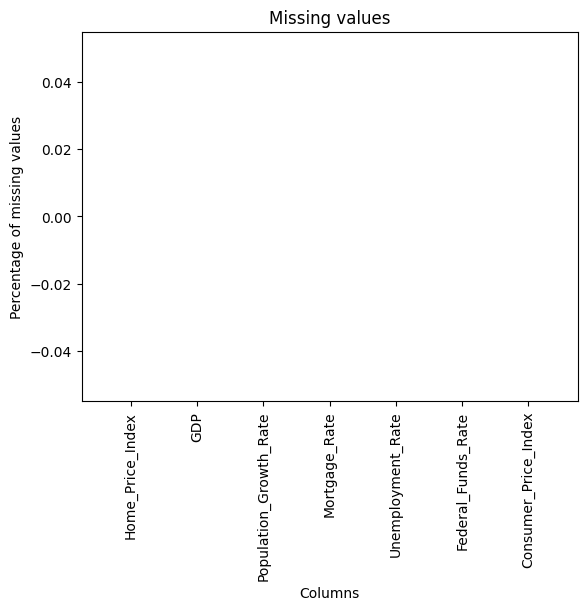

In [72]:
#checking for missing values
def visualize_null(dataframe,percentage=True):
    null_series=merged_df_cleaned.isna().sum().sort_values(ascending=False)
    if percentage:
        null_series=null_series/len(dataframe)*100

    plt.bar(x=null_series.index,height=null_series.values)

    if percentage:
        plt.ylabel('Percentage of missing values')
    else:
        plt.ylabel('Amount of missing values')
    plt.title('Missing values')
    plt.xlabel('Columns')
    plt.xticks(rotation=90)
    plt.show()

visualize_null(merged_df_cleaned)

In [73]:
merged_df_cleaned.describe()

,Home_Price_Index,GDP,Population_Growth_Rate,Mortgage_Rate,Unemployment_Rate,Federal_Funds_Rate,Consumer_Price_Index
count,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000
mean,141.143556,13236.389663,0.902092,6.321483,5.776993,3.157699,195.748155
std,60.262963,5902.255151,0.276820,2.176679,1.676957,2.679839,48.705952
min,63.964000,4722.156000,0.156747,2.684000,3.400000,0.050000,111.400000
25%,82.072500,7868.468000,0.733362,4.316250,4.600000,0.335000,155.250000
50%,140.350000,12922.656000,0.925484,6.262000,5.400000,2.960000,193.600000
75%,178.140500,17518.508000,1.129651,7.856000,6.600000,5.300000,236.002000
max,306.720000,27623.543000,1.386886,11.260000,14.700000,9.850000,304.348000


In [74]:


def highlight_max(data, color='#aec6cf'):
    '''
    Highlight the maximum value in each column.
    '''
    attr = 'background-color: {}'.format(color)
    # Get the maximum value in each column
    max_values = data.max()
    # Create a boolean DataFrame
    is_max = data == max_values
    # Apply the highlight to the entire DataFrame
    return data.style.applymap(lambda x: attr if x in max_values.values else '')

# Get the rows where the maximum value for each column is found
max_rows = pd.concat([merged_df_cleaned.loc[merged_df_cleaned[col] == merged_df_cleaned[col].max()] for col in merged_df_cleaned.columns], axis=0).drop_duplicates()

# Sort by date
max_rows_sorted = max_rows.sort_index()

# Apply the highlight_max function only to the rows with maximum values
highlighted_max_rows_sorted = highlight_max(max_rows_sorted)
highlighted_max_rows_sorted



,Home_Price_Index,GDP,Population_Growth_Rate,Mortgage_Rate,Unemployment_Rate,Federal_Funds_Rate,Consumer_Price_Index
Date,,,,,,,
1987-11-01 00:00:00,68.107000,5007.994000,0.893829,11.260000,5.800000,6.690000,115.400000
1989-03-01 00:00:00,74.778000,5511.253000,0.944406,10.645000,5.000000,9.850000,122.200000
1992-01-01 00:00:00,76.086000,6363.102000,1.386886,8.497500,7.300000,4.030000,138.300000
1992-02-01 00:00:00,76.155000,6363.102000,1.386886,8.432000,7.400000,4.060000,138.600000
1992-03-01 00:00:00,76.276000,6363.102000,1.386886,8.762500,7.400000,3.980000,139.100000
1992-04-01 00:00:00,76.345000,6470.763000,1.386886,8.935000,7.400000,3.730000,139.400000
1992-05-01 00:00:00,76.398000,6470.763000,1.386886,8.852500,7.600000,3.820000,139.700000
1992-06-01 00:00:00,76.331000,6470.763000,1.386886,8.672000,7.800000,3.760000,140.100000
1992-07-01 00:00:00,76.263000,6566.641000,1.386886,8.510000,7.700000,3.250000,140.500000


"""
### Insights from Maximum Values Across Columns

The table highlights the maximum values for each economic indicator across different years. Here are some key insights:

1. **Home Price Index (HPI)**:
    - The highest HPI value of 306.72 was observed in July 2023, indicating a significant rise in home prices in recent years.

2. **GDP**:
    - The maximum GDP value of 27,623.54 was recorded in July 2023. This suggests robust economic growth coinciding with the peak in home prices.

3. **Population Growth Rate**:
    - The population growth rate peaked at 1.3869 during multiple months in the early 1990s (January to December 1992). This period shows consistent high growth rates.

4. **Mortgage Rate**:
    - The highest mortgage rate of 11.26 was noted in November 1987. This high borrowing cost could have impacted housing affordability during that time.

5. **Unemployment Rate**:
    - The maximum unemployment rate of 14.70 was observed in April 2020, during the COVID-19 pandemic. This period saw significant economic disruption and job losses.

6. **Federal Funds Rate**:
    - The federal funds rate peaked at 9.85 in March 1989, reflecting a period of high interest rates which could have influenced borrowing and investment decisions.

7. **Consumer Price Index (CPI)**:
    - The highest CPI value of 304.35 was recorded in July 2023. This indicates significant inflationary pressures in recent years.

The data highlights significant economic events and trends over the years. The recent peaks in HPI, GDP, and CPI in 2023 suggest a robust yet inflationary economic environment. Historical peaks in mortgage rates and federal funds rates during the late 1980s and early 1990s reflect different economic conditions impacting borrowing costs. The spike in unemployment in April 2020 underscores the economic impact of the COVID-19 pandemic.

These insights provide a comprehensive understanding of the economic landscape and its impact on housing prices over the years.
"""


In [75]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import missingno as msno
import plotly.express as px
import seaborn as sns
import plotly.graph_objs as go
import plotly.io as pio

In [76]:
#@title Exploratory Data Analysis


# Define a new custom color palette
color_palette = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692']

# Line Plot: Show trends over time for different variables
fig = px.line(merged_df_cleaned, x=merged_df_cleaned.index,
              y=['Home_Price_Index', 'GDP', 'Population_Growth_Rate', 'Mortgage_Rate', 'Unemployment_Rate', 'Federal_Funds_Rate', 'Consumer_Price_Index'],
              title='Trends Over Time',
              labels={'value': 'Values', 'index': 'Date'},
              color_discrete_sequence=color_palette)

# Customize the layout for a professional appearance
fig.update_layout(
    title={
        'text': "Trends Over Time",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20}
    },
    xaxis_title='Date',
    yaxis_title='Values',
    legend_title='Variables',
    font=dict(
        family="Helvetica, sans-serif",
        size=14,
        color="#4a4a4a"
    ),
    plot_bgcolor='white',
    hovermode='x unified',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
        font=dict(size=12)
    ),
    margin=dict(l=40, r=40, t=80, b=40)
)

# Update the lines for better contrast and visual appeal
fig.update_traces(line=dict(width=3))

# Add gridlines for better readability
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

# Show the plot
fig.show()


**Trends Seen:**

***GDP (Red Line):*** Over time, the GDP has shown a steady rising trend, showing economic expansion. The financial crisis is probably the cause of the little declines that occurred in 2008 and 2009, but overall the trend has been rising.

***Additional factors:***  When compared to the GDP, they appear to be staying mostly steady. This could mean that although GDP has grown significantly, other economic indices have not changed as much.

**Significant Events**

- A discernible decline in GDP occurs in the years 2008–2009, coinciding with the global financial crisis.
- The GDP is trending upward after 2020, which could be attributed to the COVID-19 pandemic recovery period.




In [77]:
import pandas as pd
import plotly.graph_objects as go

def plot_line_chart(df, y, title, line_color, fill_color):
    fig = go.Figure()

    # Add the main trace
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df[y],
        mode='lines',
        name=title,
        line=dict(color=line_color, width=2),
        fill='tozeroy',
        fillcolor=fill_color,
        opacity=0.8
    ))

    # Highlight global maximum and minimum
    max_value = df[y].max()
    min_value = df[y].min()

    fig.add_trace(go.Scatter(
        x=df[df[y] == max_value].index,
        y=[max_value] * len(df[df[y] == max_value]),
        mode='markers+text',
        marker=dict(color=line_color, size=10),
        text=['Max'] * len(df[df[y] == max_value]),
        textposition='top center',
        name='Global Max'
    ))

    fig.add_trace(go.Scatter(
        x=df[df[y] == min_value].index,
        y=[min_value] * len(df[df[y] == min_value]),
        mode='markers+text',
        marker=dict(color=line_color, size=10),
        text=['Min'] * len(df[df[y] == min_value]),
        textposition='bottom center',
        name='Global Min'
    ))

    layout = dict(
        title=title,
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=6,
                         label='6 months',
                         step='month',
                         stepmode='backward'),
                    dict(count=1,
                         label='1 year',
                         step='year',
                         stepmode='backward'),
                    dict(count=2,
                         label='2 years',
                         step='year',
                         stepmode='backward'),
                    dict(count=5,
                         label='5 years',
                         step='year',
                         stepmode='backward'),
                    dict(count=10,
                         label='10 years',
                         step='year',
                         stepmode='backward'),
                    dict(count=15,
                         label='15 years',
                         step='year',
                         stepmode='backward'),
                    dict(step='all')
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type='date',
            showgrid=True,  # Add gridlines
            gridcolor='LightGray'
        ),
        yaxis=dict(
            title=y,
            showgrid=True,  # Add gridlines
            gridcolor='LightGray'
        ),
        plot_bgcolor='white'
    )

    fig.update_layout(layout)
    fig.show()



# Home Price Index
plot_line_chart(merged_df_cleaned, y='Home_Price_Index', title='Home Price Index Over Time',
                line_color='#1f77b4', fill_color='rgba(31, 119, 180, 0.1)')


"Home Price Index Over Time" displays the changes in the Home Price Index from around 1985 to 2025. Here are the key points:

**Overall Trend:**

The Home Price Index shows a general upward trend over the entire period.
Significant Points:

***Min (Global Min):*** The lowest point on the graph occurs around 1985, marking the minimum value of the Home Price Index.

***Max (Global Max):*** The highest point on the graph occurs around 2025, marking the maximum value of the Home Price Index.

**Key Periods:**

***1985-2000:*** The index shows a steady but gradual increase.

***2000-2008:*** There is a noticeable rise in the Home Price Index, peaking around 2008.

***2008-2010:*** The index dips slightly, reflecting the impact of the financial crisis.

***2010-2020:*** A recovery period with a steady increase in the index.

***2020-2025:*** A sharp rise in the index, reaching its peak in 2024.

On the graph, markers for the global minimum and maximum values make it easier to spot important places. In conclusion, the graph shows the evolution of the Home Price Index over the course of the last forty years, with notable highs and lows that correspond to important turning points in the economy, most notably the rise prior to 2008, the subsequent decline, and the rapid upsurge after 2020.


In [78]:
#@title Unemployment Rate
plot_line_chart(merged_df_cleaned, y='Unemployment_Rate', title='Unemployment Rate Over Time',
                line_color='#ff7f0e', fill_color='rgba(255, 127, 14, 0.1)')


The "Unemployment Rate Over Time" graph illustrates how unemployment rates changed from roughly 1985 to 2025. It draws attention to times when there have been notable ups and downs. Between 1985 and 1995, the unemployment rate consistently decreased; nevertheless, between 1995 and 2005, there were noticeable surges in the rate around 1992 and 2002. The financial crisis caused the jobless rate to significantly increase about 2010, after which it steadily declined until 2020.

The COVID-19 pandemic's effects are probably to blame for the unemployment rate's dramatic jump in 2020, which corresponds to the graph's greatest point. The rate then declines sharply after peaking, dropping to its lowest point about in 2024. The graph makes it simpler to identify critical points by including markers for the global minimum and maximum values, as well as a shaded area under the curve that graphically represents the range of the unemployment rate over time.

In [79]:
#@title GDP
plot_line_chart(merged_df_cleaned, y='GDP', title='GDP Over Time',
                line_color='#2ca02c', fill_color='rgba(44, 160, 44, 0.1)')

The Gross Domestic Product (GDP) is shown in the "GDP Over Time" graph from approximately 1985 to 2025. It has a constant increasing trend across the years, suggesting persistent economic growth. The graph's lowest point, representing the minimum GDP value, is located around 1985. After then, the GDP grows gradually, with a brief decline in 2008–2009 that is indicative of the world financial crisis. Following this time frame, the GDP keeps growing, indicating recovery and expansion.

The graph's greatest point, which represents the maximum GDP value, is located around in 2024. This time frame exhibits a notable growth, particularly around 2020, which may be related to attempts to revive the economy after the COVID-19 epidemic. The graph provides distinct reference points by including markers for the global minimum and maximum values as well as shaded sections that graphically depict the GDP's range throughout time.


In [80]:
#@title Population Growth Rate
plot_line_chart(merged_df_cleaned, y='Population_Growth_Rate', title='Population Growth Rate Over Time',
                line_color='#d62728', fill_color='rgba(214, 39, 40, 0.1)')

The "Population Growth Rate Over Time" graph shows how the population growth rate changed from around 1985 to 2025. The graph illustrates notable variations in the growth rate over the course of several decades. The population growth rate first rises consistently from 1985 to the early 1990s, peaking about in 1992. On the graph, this time period represents the worldwide maximum. Following the peak, the growth rate gradually declines during the 1990s and the first part of the 2000s, stabilising slightly but still declining progressively into the 2010s.

The global lowest point is reached around 2020, when there is a discernible abrupt fall that indicates a substantial decline in the rate of population expansion. A minor uptick occurs after this, but the growth rate is still modest when compared to previous decades. In order to readily identify these important points, the graph features markers for the global lowest and maximum values as well as shaded sections that highlight the range of the population growth rate over time.


In [81]:
#@title Federal Funds Rate
plot_line_chart(merged_df_cleaned, y='Federal_Funds_Rate', title='Federal Funds Rate Over Time',
                line_color='#9467bd', fill_color='rgba(148, 103, 189, 0.1)')

The Federal Funds Rate's fluctuations from roughly 1985 to 2025 are depicted in the graph named "Federal Funds Rate Over Time". Throughout this time, there have been notable swings in the Federal Funds Rate—the interest rate used by depository institutions to transact federal funds with one another overnight. The global maximum point is shown by a peak on the graph that appears to be around the late 1980s. Following this high, there follows a slow decrease in the early 1990s, which is followed by a very stable phase in the mid-1990s. There is another noteworthy increase in the early 2000s, and then the rate sharply declines to extremely low levels after the 2008 financial crisis.

The Federal Funds Rate stays very low after 2010 but begins to rise gradually around 2015. This rise lasts until about 2020, when the rate abruptly declines once more, most likely as a result of the COVID-19 pandemic's economic effects. This represents the graph's worldwide minimum point. The graph shows a clear climb at the end that indicates an increase in the Federal Funds Rate after 2020, following this low. The markers for the global maximum and minimum values establish distinct reference points, and the shaded area under the curve shows how the rate changes over time.

In [82]:
#@title Mortgage Rate
plot_line_chart(merged_df_cleaned, y='Mortgage_Rate', title='Mortgage Rate Over Time',
                line_color='#8c564b', fill_color='rgba(140, 86, 75, 0.1)')

The "Mortgage Rate Over Time" graph shows how mortgage rates have changed from around 1985 to 2025. The graph indicates the global maximum point for mortgage rates, which peaked in the late 1980s. There is a noticeable fall in the early 1990s after this high. Over the course of the following ten years, the rates continue to progressively decline with sporadic fluctuations, indicating a general decreasing trend.

The worldwide minimum on the graph, which corresponds to the lowest mortgage rates globally, is reached about 2010. After 2010, the rates stay low but do show some growth towards the end of the decade, particularly in the 2020–2025 range, indicating a significant increase in rates. The variations in mortgage rates over time are depicted by the shaded region under the curve, and noteworthy spots can be found by using the markers for the global maximum and minimum values.

In [83]:
#@title Consumer Price Index
plot_line_chart(merged_df_cleaned, y='Consumer_Price_Index', title='Consumer Price Index Over Time',
                line_color='#e377c2', fill_color='rgba(227, 119, 194, 0.1)')

The "Consumer Price Index Over Time" graph shows how the Consumer Price Index (CPI) changed between roughly 1985 and 2025. Over this time, there has been a consistent rise in the Consumer Price Index (CPI), which tracks the average change in consumer prices for goods and services over time. The graph's lowest point, which represents the CPI's global minimum value, is located around 1985. From this point on, there is a steady upward trend that reflects inflation that occurs gradually as the cost of goods and services rises over time.

The CPI reaches its peak around the conclusion of the era, or about 2025, designating the worldwide maximum value on the graph. This time frame exhibits a significant increase, particularly after 2020, suggesting a more rapid growth in consumer prices, maybe as a result of market modifications and attempts to revive the economy after the COVID-19 epidemic. Clear reference points are provided by the markers for the global minimum and maximum values, and the shaded area under the curve highlights the CPI's range over time.


In [84]:
#@title Relationship between Home Price Index and GDP

# Scatter Plot with Regression Line: Show relationship between Home Price Index and GDP
fig = px.scatter(merged_df_cleaned, x='GDP', y='Home_Price_Index',
                 title='Home Price Index vs GDP',
                 labels={'GDP': 'GDP', 'Home_Price_Index': 'Home Price Index'},
                 trendline='ols',  # adds an OLS regression line
                 color_discrete_sequence=['#636EFA'])

# Customizing the layout
fig.update_layout(
    title={
        'text': "Home Price Index vs GDP",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20}
    },
    xaxis_title='GDP',
    yaxis_title='Home Price Index',
    font=dict(
        family="Helvetica, sans-serif",
        size=14,
        color="#4a4a4a"
    ),
    plot_bgcolor='white',
    hovermode='closest',
    margin=dict(l=40, r=40, t=80, b=40)
)

# Add gridlines for better readability
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

# Enhance the tooltips for more informative hover data
fig.update_traces(marker=dict(size=10, opacity=0.8, line=dict(width=1, color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

# Add trendline results to the plot
results = px.get_trendline_results(fig)
ols_results = results.iloc[0]["px_fit_results"]
trendline_info = f"y = {ols_results.params[1]:.2f}x + {ols_results.params[0]:.2f}, R² = {ols_results.rsquared:.2f}"

fig.add_annotation(
    xref="paper", yref="paper",
    x=0.05, y=0.95,
    showarrow=False,
    text=trendline_info,
    font=dict(size=14)
)

# Show the plot
fig.show()


The "Home Price Index vs. GDP" graph shows a fitted linear regression line and a scatter plot of the Home Price Index against GDP. Plotting the GDP is done on the horizontal axis, and plotting the Home Price Index is done on the vertical. A data point illustrating the relationship between the GDP and the Home Price Index at a specific point in time is shown by each blue dot.

Key observations from the graph include:

1. **Positive Correlation**: The scatter plot shows a clear positive correlation between GDP and the Home Price Index, indicating that as GDP increases, the Home Price Index also tends to increase. This relationship is reinforced by the upward-sloping linear regression line.

2. **Linear Regression**: The equation of the fitted line is \( y = 0.01x + 11.27 \), where \( y \) represents the Home Price Index and \( x \) represents GDP. The \( R^2 \) value of 0.92 indicates a strong correlation between the two variables, suggesting that 92% of the variance in the Home Price Index can be explained by GDP.

3. **Trends and Deviations**: While most data points closely follow the linear trend, there are some deviations, particularly around the mid-range of GDP values (approximately 15k), where the data points exhibit more spread. This indicates periods where the relationship between GDP and the Home Price Index was not perfectly linear, possibly due to economic anomalies or other influencing factors.

Overall, the graph effectively demonstrates a strong positive relationship between GDP and the Home Price Index, with the fitted regression line providing a good predictive model for the Home Price Index based on GDP.

In [85]:
#@title Boxplot of all Variables
# Define a new custom color palette
color_palette = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692']

# Box Plot: Show the distribution of multiple variables
fig = px.box(merged_df_cleaned,
             y=['Home_Price_Index', 'GDP', 'Population_Growth_Rate', 'Mortgage_Rate', 'Unemployment_Rate', 'Federal_Funds_Rate', 'Consumer_Price_Index'],
             title='Box Plot of Multiple Variables',
             color_discrete_sequence=color_palette)

# Customize the layout for a professional appearance
fig.update_layout(
    title={
        'text': "Box Plot of Multiple Variables",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20}
    },
    yaxis_title='Values',
    font=dict(
        family="Helvetica, sans-serif",
        size=14,
        color="#4a4a4a"
    ),
    plot_bgcolor='white',
    hovermode='closest',
    margin=dict(l=40, r=40, t=80, b=40)
)

# Add gridlines for better readability
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

# Show the plot
fig.show()




The "Box Plot of Multiple Variables" graph shows box plots that summarise the distribution, central tendency, and variability of a number of economic variables. The Home Price Index, GDP, Population Growth Rate, Mortgage Rate, Unemployment Rate, Federal Funds Rate, and Consumer Price Index are the variables that are displayed in the box plot.

### Key Observations:

1. **GDP (Gross Domestic Product)**:
   - **Range**: The GDP has the largest range among the variables, extending from approximately 5,000 to 27,500.
   - **Interquartile Range (IQR)**: The IQR, which is the box itself, ranges from about 10,000 to 17,500.
   - **Median**: The median value of GDP is around 14,000, indicated by the line inside the box.
   - **Whiskers**: The whiskers extend from the lower quartile to around 5,000 and from the upper quartile to about 27,500.

2. **Other Variables**:
   - **Home Price Index, Population Growth Rate, Mortgage Rate, Unemployment Rate, Federal Funds Rate, Consumer Price Index**:
     - These variables have much smaller ranges compared to GDP.
     - Each of these variables shows relatively low variability, with the box plots being very compressed, indicating tight distribution around their median values.
     - The medians and ranges for these variables are not easily distinguishable due to their small scale when plotted alongside GDP.

### Summary:

The substantial disparity in scale and variability between GDP and the other economic indicators is clearly brought to light by the box plot. The other indicators show far smaller ranges and lower variability than the GDP, which shows a huge range and considerable variability. This discrepancy implies that GDP levels are significantly higher and more volatile over time than the other variables, which stay mostly constant. The distributions of these economic variables can be quickly compared thanks to the box plot's succinct visual description.

In [86]:
#@title Correlation Matrix
# Define a custom color scale
color_scale = [
    [0, 'blue'],
    [0.5, 'white'],
    [1, 'red']
]

# Calculate the correlation matrix
correlation_matrix = merged_df_cleaned.corr()

# Mask the lower triangle of the correlation matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
masked_correlation_matrix = correlation_matrix.mask(~mask)

# Plot the correlation matrix using Plotly with the custom color scale
fig = px.imshow(
    masked_correlation_matrix,
    text_auto=".2f",
    color_continuous_scale=color_scale
)
# Update hover template for custom tooltips
fig.update_traces(
    hovertemplate="<b> %{x}</b><br>" +
                  "<b>& %{y}</b><br>" +
                  "<b>Correlation: %{z:.2f}</b><extra></extra>"
)

# Update the layout to add titles and improve appearance
fig.update_layout(
    title="Correlation Matrix"
)

# Show the plot
fig.show()

Home Price Index, GDP, Population Growth Rate, Mortgage Rate, Unemployment Rate, Federal Funds Rate, and Consumer Price Index are among the economic indicators that are represented by the graph, which is a correlation matrix. The correlation coefficient between the variables is represented by each cell in the matrix, which ranges from -1 to 1. Red denotes a strong positive correlation and blue denotes a strong negative correlation. The colour gradient between blue and red represents the intensity and direction of the association.

### Key Observations:

1. **Strong Positive Correlations**:
   - **Home Price Index and GDP (0.96)**: There is a very strong positive correlation between the Home Price Index and GDP, suggesting that as GDP increases, the Home Price Index tends to increase as well.
   - **GDP and Consumer Price Index (0.99)**: Similarly, there is an almost perfect positive correlation between GDP and the Consumer Price Index, indicating that GDP growth is closely associated with increases in the Consumer Price Index.
   - **Mortgage Rate and Unemployment Rate (0.90)**: There is a strong positive correlation between the Mortgage Rate and the Unemployment Rate, suggesting that higher mortgage rates are associated with higher unemployment rates.

2. **Strong Negative Correlations**:
   - **GDP and Population Growth Rate (-0.85)**: There is a strong negative correlation between GDP and Population Growth Rate, indicating that higher GDP is associated with lower population growth rates.
   - **Consumer Price Index and Population Growth Rate (-0.81)**: There is a strong negative correlation between the Consumer Price Index and the Population Growth Rate, suggesting that as consumer prices rise, population growth tends to slow down.
   - **Consumer Price Index and Federal Funds Rate (-0.73)**: There is a notable negative correlation between the Consumer Price Index and the Federal Funds Rate, indicating that higher consumer prices are associated with lower federal funds rates.

3. **Mixed and Weak Correlations**:
   - The correlations between Population Growth Rate and other variables, such as GDP, Mortgage Rate, and Unemployment Rate, vary, showing both positive and negative but generally weaker relationships.
   - The correlation between Unemployment Rate and Consumer Price Index is very weak (-0.07), indicating little to no direct relationship between these two variables.

### Summary:

The correlation matrix offers a thorough summary of the connections between important economic variables. Certain indicators, like GDP and the Home Price Index and Consumer Price Index, appear to move together when there are strong positive correlations between them. On the other hand, inverse associations, like the one between GDP and population growth rate, are indicated by significant negative correlations. These relationships are efficiently brought to light by the matrix, which also offers insights into the ways in which these economic indicators interact.

# The Classification for USA National S&P Case-Shiller Housing Price Index Growth Rate vs. FED Funds Rate

"""
### Overview
The classification for USA National S&P Case-Shiller Housing Price Index growth rate compared to the FED Funds Rate is a significant metric for investors, as it influences their investment decisions and potential returns.

### Importance for Investors
Understanding the relationship between these two rates is crucial for investors. The Federal Funds Rate, a benchmark interest rate, influences borrowing costs, including mortgages. When the Housing Price Index growth rate is lower than the Federal Funds Rate, it could signal a slowing housing market, potentially deterring investment in real estate. Conversely, if the index's growth rate is higher, it might indicate a robust market where real estate investments could appreciate.

### Investment Implications
Accurately predicting this relationship helps investors gauge the risk and timing for entering or exiting real estate investments. In the dynamic realm of real estate economics, accurately predicting market trends is essential for informed decision-making.

### Conclusion
Understanding and predicting the relationship between the Housing Price Index growth rate and the Federal Funds Rate is vital for making strategic investment decisions. It enables investors to better manage risks and optimize their investment returns.
"""


# Random Forest Classifier Model

"""
### Introduction to Random Forest Classifier

Random Forest is a versatile and widely-used ensemble learning method for classification, regression, and other tasks. It operates by constructing multiple decision trees during training and outputting the class that is the mode of the classes (classification) or the mean prediction (regression) of the individual trees. The main advantages of Random Forest are its ability to handle large datasets with higher dimensionality and its robustness to overfitting.



![fig](https://miro.medium.com/v2/resize:fit:592/1*i0o8mjFfCn-uD79-F1Cqkw.png)

### Key Steps in Implementing Random Forest Classifier


1. **Defining the Target Variable**:
    - The target variable, in this case, is the investment decision based on the growth rate of the Home Price Index (HPI) compared to the Federal Funds Rate.
    - The decisions are categorized as 'Buy', 'Sell', or 'Hold'.

2. **Data Preparation**:
    - Calculate the growth rate of the Home Price Index.
    - Define the target variable based on the given condition.
    - Shift the columns to ensure that the model uses past data for forecasting.

3. **Model Training and Evaluation**:
    - Split the data into training and testing sets.
    - Train the Random Forest Classifier.
    - Evaluate the model using accuracy score, confusion matrix, and classification report.

### Implementation

Below is the implementation of the Random Forest Classifier:




In [87]:
#@title Random Forest Classifier Model 1
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import plotly.graph_objects as go


# Step 1: Define the target variable

# Calculate the growth rate of the Home Price Index
merged_df_cleaned['HPI_Growth_Rate'] = merged_df_cleaned['Home_Price_Index'].pct_change().fillna(0) * 100

# Define the target variable based on the given condition
conditions = [
    (merged_df_cleaned['HPI_Growth_Rate'] < merged_df_cleaned['Federal_Funds_Rate']),
    (merged_df_cleaned['HPI_Growth_Rate'] > merged_df_cleaned['Federal_Funds_Rate'])
]
choices = ['Sell', 'Buy']
merged_df_cleaned['Decision'] = np.select(conditions, choices, default='Hold')


# Columns to shift
columns_to_shift = ['Home_Price_Index', 'GDP', 'Population_Growth_Rate', 'Mortgage_Rate',
                    'Unemployment_Rate', 'Federal_Funds_Rate', 'Consumer_Price_Index', 'HPI_Growth_Rate']

# Check if the first row's index is '1987-01-01' and 'Home_Price_Index' is not NaN
if merged_df_cleaned.index[0] == pd.Timestamp('1987-01-01') and not pd.isna(merged_df_cleaned.loc['1987-01-01', 'Home_Price_Index']):

    merged_df_cleaned[columns_to_shift] = merged_df_cleaned[columns_to_shift].shift(12)

    # Optionally, remove rows with NaN values that result from the shift
    merged_df_cleaned.dropna(inplace=True)

merged_df_cleaned




,Home_Price_Index,GDP,Population_Growth_Rate,Mortgage_Rate,Unemployment_Rate,Federal_Funds_Rate,Consumer_Price_Index,HPI_Growth_Rate,Decision
Date,,,,,,,,,
1988-01-01,63.964,4722.156,0.893829,9.3100,6.6,6.43,111.400,0.000000,Sell
1988-02-01,64.424,4722.156,0.893829,9.2040,6.6,6.10,111.800,0.719155,Sell
1988-03-01,64.736,4722.156,0.893829,9.0825,6.6,6.13,112.200,0.484292,Sell
1988-04-01,65.132,4806.160,0.893829,9.0350,6.3,6.37,112.700,0.611715,Sell
1988-05-01,65.563,4806.160,0.893829,9.8325,6.3,6.85,113.000,0.661733,Sell
...,...,...,...,...,...,...,...,...,...
2023-03-01,296.228,25029.116,0.377565,3.7625,3.6,0.20,287.472,1.823157,Sell
2023-04-01,300.569,25544.273,0.377565,4.1720,3.6,0.33,288.611,1.465425,Sell
2023-05-01,303.863,25544.273,0.377565,4.9825,3.6,0.77,291.268,1.095921,Sell


In [88]:
#@title Plot of rfc

# Create traces
trace1 = go.Scatter(
    x=merged_df_cleaned.index,
    y=merged_df_cleaned['HPI_Growth_Rate'],
    mode='lines',
    name='HPI Growth Rate'
)

trace2 = go.Scatter(
    x=merged_df_cleaned.index,
    y=merged_df_cleaned['Federal_Funds_Rate'],
    mode='lines',
    name='Federal Funds Rate'
)

# Create the figure with both traces
fig = go.Figure(data=[trace1, trace2])

# Update the layout
fig.update_layout(
    title='Time Series Plot of HPI Growth Rate and Federal Funds Rate',
    xaxis_title='Date',
    yaxis_title='Rate',
    legend_title='Legend'
)

# Show the plot
fig.show()

# Use Past Data for Forecasting (One Year)

"""
Incorporating lagged values from the previous year in predictive modeling is crucial for addressing two key issues: the availability of current-time data and the prevention of data leakage.

### Availability of Current-Time Data
Many real-world scenarios, especially in economic forecasting, face delays in data collection, processing, or reporting, making real-time data not always immediately available. Using lagged values allows models to operate effectively without relying on the immediate availability of current data, thus enabling decisions to be made based on the most recently completed dataset.

### Prevention of Data Leakage
Data leakage is a common problem where a model inadvertently accesses future information it wouldn't normally have during the prediction phase. By using data from the previous year, the model simulates real-world conditions more accurately, ensuring it does not have access to future information that could unduly influence its predictions.


This approach ensures the model's applicability in realistic scenarios, maintaining robustness and relevance in practical applications.
"""


In [89]:
# Display the distribution of the target variable
print(merged_df_cleaned['Decision'].value_counts())

# Step 2: Prepare features and target variable

# Define the features and target
features = merged_df_cleaned.drop(columns=['Home_Price_Index', 'HPI_Growth_Rate', 'Decision'])
target = merged_df_cleaned['Decision']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 3: Train the Random Forest Classifier

# Train the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Step 4: Evaluate the model

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)


Decision
Sell    337
Buy      90
Name: count, dtype: int64
Accuracy: 1.0
Confusion Matrix:
[[10  0]
 [ 0 76]]
Classification Report:
              precision    recall  f1-score   support

         Buy       1.00      1.00      1.00        10
        Sell       1.00      1.00      1.00        76

    accuracy                           1.00        86
   macro avg       1.00      1.00      1.00        86
weighted avg       1.00      1.00      1.00        86



In [90]:
#@title SMOTE Improved model
!pip install imbalanced-learn

# Addressing Class Imbalance with SMOTE

"""
### Problem with Unbalanced Datasets
When dealing with classification tasks in machine learning, an unbalanced dataset can lead to biased models that disproportionately favor the majority class. In this case, with the 'Decision' variable having significantly more 'Sell' instances (337) compared to 'Buy' instances (90), there is a risk that the model might become biased towards predicting 'Sell', potentially ignoring the nuances that might lead to a 'Buy' decision.

### Introducing SMOTE

![fig](https://miro.medium.com/v2/resize:fit:850/1*QaNfJwU6P-VnG1zp3U4cVg.png)

To address this imbalance and create a more generalizable model, the Synthetic Minority Over-sampling Technique (SMOTE) can be employed. SMOTE is an advanced over-sampling method that works by creating synthetic samples from the minority class ('Buy' in this instance) instead of creating exact copies. This technique involves randomly picking a point from the minority class and computing the k-nearest neighbors for this point; the synthetic points are then added between the chosen point and its neighbors.

### Benefits of SMOTE
This approach helps by artificially boosting the representation of the minority class in the training set, which can help mitigate the risk of overfitting to the majority class and allows the model to learn more general patterns across both classes. By applying SMOTE, you ensure that the decision boundary derived by the classifier does not bias towards the majority class and improves the model's overall accuracy and predictive performance on unseen data, especially for the underrepresented class.

### Conclusion
This method is particularly useful when the class imbalance is severe, as it is in your dataset. Using SMOTE, you can enhance the classifier's ability to make balanced predictions, leading to a more robust and fair model.
"""


In [91]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd


# Step 1: Define the target variable

# Calculate the growth rate of the Home Price Index
merged_df_cleaned['HPI_Growth_Rate'] = merged_df_cleaned['Home_Price_Index'].pct_change().fillna(0) * 100

# Define the target variable based on the given condition
conditions = [
    (merged_df_cleaned['HPI_Growth_Rate'] < merged_df_cleaned['Federal_Funds_Rate']),
    (merged_df_cleaned['HPI_Growth_Rate'] > merged_df_cleaned['Federal_Funds_Rate'])
]
choices = ['Sell', 'Buy']
merged_df_cleaned['Decision'] = np.select(conditions, choices, default='Hold')

# Columns to shift
columns_to_shift = ['Home_Price_Index', 'GDP', 'Population_Growth_Rate', 'Mortgage_Rate',
                    'Unemployment_Rate', 'Federal_Funds_Rate', 'Consumer_Price_Index', 'HPI_Growth_Rate']

# Check if the first row's index is '1987-01-01' and 'Home_Price_Index' is not NaN
if merged_df_cleaned.index[0] == pd.Timestamp('1987-01-01') and not pd.isna(merged_df_cleaned.loc['1987-01-01', 'Home_Price_Index']):
    merged_df_cleaned[columns_to_shift] = merged_df_cleaned[columns_to_shift].shift(12)
    merged_df_cleaned.dropna(inplace=True)

# Display the distribution of the target variable
print(merged_df_cleaned['Decision'].value_counts())

# Step 2: Prepare features and target variable

# Define the features and target
features = merged_df_cleaned.drop(columns=['Home_Price_Index', 'HPI_Growth_Rate', 'Decision'])
target = merged_df_cleaned['Decision']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 3: Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Step 4: Train the Random Forest Classifier

# Train the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_smote, y_train_smote)

# Step 5: Evaluate the model

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)


Decision
Sell    337
Buy      90
Name: count, dtype: int64
Accuracy: 0.9418604651162791
Confusion Matrix:
[[12  0]
 [ 5 69]]
Classification Report:
              precision    recall  f1-score   support

         Buy       0.71      1.00      0.83        12
        Sell       1.00      0.93      0.97        74

    accuracy                           0.94        86
   macro avg       0.85      0.97      0.90        86
weighted avg       0.96      0.94      0.95        86



In [92]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import pandas as pd



# Step 1: Define the target variable

# Calculate the growth rate of the Home Price Index
merged_df_cleaned['HPI_Growth_Rate'] = merged_df_cleaned['Home_Price_Index'].pct_change().fillna(0) * 100

# Define the target variable based on the given condition
conditions = [
    (merged_df_cleaned['HPI_Growth_Rate'] < merged_df_cleaned['Federal_Funds_Rate']),
    (merged_df_cleaned['HPI_Growth_Rate'] > merged_df_cleaned['Federal_Funds_Rate'])
]
choices = ['Sell', 'Buy']
merged_df_cleaned['Decision'] = np.select(conditions, choices, default='Hold')

# Columns to shift
columns_to_shift = ['Home_Price_Index', 'GDP', 'Population_Growth_Rate', 'Mortgage_Rate',
                    'Unemployment_Rate', 'Federal_Funds_Rate', 'Consumer_Price_Index', 'HPI_Growth_Rate']

# Check if the first row's index is '1987-01-01' and 'Home_Price_Index' is not NaN
if merged_df_cleaned.index[0] == pd.Timestamp('1987-01-01') and not pd.isna(merged_df_cleaned.loc['1987-01-01', 'Home_Price_Index']):
    merged_df_cleaned[columns_to_shift] = merged_df_cleaned[columns_to_shift].shift(12)
    merged_df_cleaned.dropna(inplace=True)

# Display the distribution of the target variable
print(merged_df_cleaned['Decision'].value_counts())

# Step 2: Prepare features and target variable

# Define the features and target
features = merged_df_cleaned.drop(columns=['Home_Price_Index', 'HPI_Growth_Rate', 'Decision'])
target = merged_df_cleaned['Decision']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 3: Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)

# Create a pipeline with SMOTE and RandomForestClassifier
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Step 4: Evaluate the best model

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)


Decision
Sell    337
Buy      90
Name: count, dtype: int64
Best Parameters: {'classifier__bootstrap': False, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}
Accuracy: 0.9418604651162791
Confusion Matrix:
[[12  0]
 [ 5 69]]
Classification Report:
              precision    recall  f1-score   support

         Buy       0.71      1.00      0.83        12
        Sell       1.00      0.93      0.97        74

    accuracy                           0.94        86
   macro avg       0.85      0.97      0.90        86
weighted avg       0.96      0.94      0.95        86



In [93]:
#@title Feature Importance

# Calculate feature importances
feature_importances = clf.feature_importances_

# Create a DataFrame to store feature names and their corresponding importances
importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by the 'Importance' column in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Round the importance values to 3 decimal places
importance_df['Importance'] = importance_df['Importance'].round(3)

# Plot the feature importances using Plotly
fig = px.bar(importance_df, x='Importance', y='Feature', orientation='h',
             title='Feature Importances from Random Forest',
             labels={'Importance': 'Importance', 'Feature': 'Feature'},
             text='Importance')

# Customize the layout
fig.update_layout(
    xaxis_title='Importance',
    yaxis_title='Feature',
    yaxis=dict(categoryorder='total ascending'),  # Invert y-axis to have the most important feature on top
    plot_bgcolor='white',
    font=dict(family="Helvetica, sans-serif", size=14, color="#4a4a4a"),
    hovermode='closest'
)

# Show the importance values on the bars with 3 decimal places
fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')

# Show the plot
fig.show()


The bar chart depicts feature importances from a Random Forest model predicting whether the growth rate of the USA National S&P Case-Shiller Housing Price Index is lower than the Federal Funds Rate. The most influential feature is the Federal Funds Rate, with an importance score of approximately 0.245, indicating its significant role in the model's predictions. Close behind are the Consumer Price Index and the Gross Domestic Product (GDP), with importance scores of about 0.237 and 0.212, respectively, both crucial for assessing economic conditions and housing market health. The Unemployment Rate and Mortgage Rate also contribute to the model with scores of 0.127 and 0.110. The Population Growth Rate has the least impact, scoring 0.070, suggesting that demographic changes have a smaller immediate effect on this model compared to economic factors.